Нейроконсультатнт с поддержкой диалога (контекста)

In [ ]:
!pip install -q langchain_openai==0.0.2 faiss-cpu==1.7.4 openai==1.6.1 tiktoken==0.5.2 langchain_community==0.0.11 langchain==0.1.0 cohere
!pip install pydantic pydantic-settings

In [ ]:
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
import os
import re
import datetime
from langchain.docstore.document import Document
import requests
from openai import OpenAI
import tiktoken
import matplotlib.pyplot as plt

# --------------------------------------------------------------
from pydantic import SecretStr
from pydantic_settings import BaseSettings, SettingsConfigDict

class Settings(BaseSettings):
    model_config = SettingsConfigDict(env_file='input',
                                      env_file_encoding='utf-8')
    openai_api_key: SecretStr

os.environ['OPENAI_API_KEY'] = Settings().openai_api_key.get_secret_value()
client = OpenAI()

In [ ]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)
    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text
    return text


def text_to_markdown(text):
    # Добавляем заголовок 1 уровня на основе римских чисел (без переноса строки)
    # и дублируем его строчкой ниже - иначе эта информация перенесется в метаданные, а порой она бывает полезной.
    def replace_header1(match):
        return f"# {match.group(2)}\n{match.group(2)}"
    text = re.sub(r'^(I{1,3}|IV|V|VI{1,3}|IX)\. (.+)', replace_header1, text, flags=re.M)
    # Добавляем текст, выделенный жирным шрифтом (он заключен между *)
    # и дублируем его строчкой ниже
    def replace_header2(match):
        return f"## {match.group(1)}\n{match.group(1)}"
    text = re.sub(r'\*([^\*]+)\*', replace_header2, text)
    return text

# База данных (Ссылка изменена)
database = load_document_text('https://docs.google.com/document/d/1YhFGR9fZDNTeE3eJ-yXskxZB85LsTRYvXjZ9Ij-t3Gw/edit?usp=sharing')
markdown = text_to_markdown(database)


Fragment Token Counts: [106, 990, 6934, 489, 231, 20029, 839, 25454, 653, 10082]

Source Chunk Token Counts: [106, 629, 361, 677, 699, 670, 634, 731, 623, 522, 712, 687, 680, 299, 489, 231, 640, 670, 615, 703, 690, 727, 709, 667, 648, 688, 716, 723, 652, 705, 710, 580, 695, 741, 605, 738, 734, 698, 729, 718, 647, 720, 732, 699, 730, 680, 159, 672, 683, 730, 716, 720, 715, 676, 658, 617, 628, 718, 719, 675, 732, 604, 729, 539, 702, 645, 731, 664, 729, 708, 534, 678, 678, 692, 716, 698, 715, 676, 633, 655, 655, 523, 666, 721, 504, 653, 708, 728, 716, 736, 732, 737, 715, 674, 726, 741, 707, 720, 743, 689] 



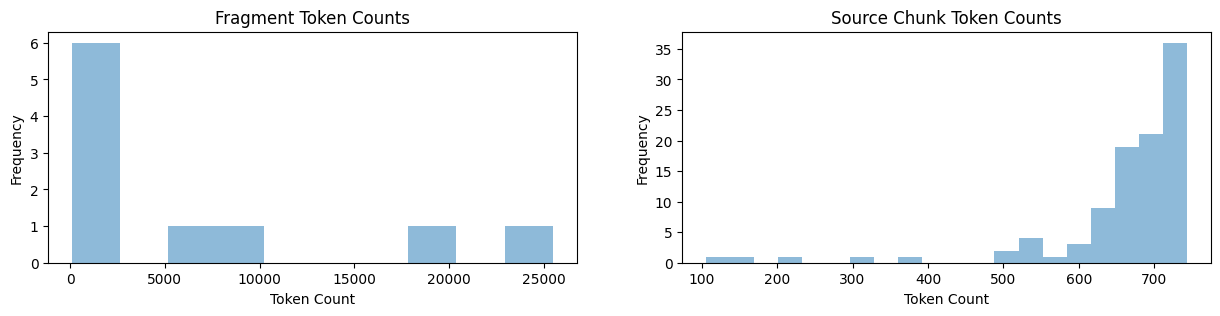


fragments:  10
source_chunks:  100


In [ ]:
def num_tokens_from_string(string, encoding_name):
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens


def hist_plot(fragments, source_chunks):
    # Подсчет токенов для каждого fragment
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    print('\nFragment Token Counts:', fragment_token_counts)
    # Подсчет токенов для каждого source_chunk
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]
    print('\nSource Chunk Token Counts:', source_chunk_token_counts, '\n')

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    ax1.hist(fragment_token_counts, bins=10, alpha=0.5, label='Fragments')
    ax1.set_title('Fragment Token Counts')
    ax1.set_xlabel('Token Count')
    ax1.set_ylabel('Frequency')
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    ax2.set_title('Source Chunk Token Counts')
    ax2.set_xlabel('Token Count')
    ax2.set_ylabel('Frequency')
    plt.show()


def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=0,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )
    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]
    hist_plot(fragments, source_chunks)
    return fragments, source_chunks


fragments, source_chunks = split_text(markdown, 750)
print("\nfragments: ", len(fragments))
print("source_chunks: ", len(source_chunks))

In [ ]:
embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(source_chunks, embeddings)

def chunks_and_scores(query):
    docs_and_scores = db.similarity_search_with_score(query, k=4)
    print("№1:", docs_and_scores[0][0].page_content[:100], ' | ', docs_and_scores[0][1])
    print("№2:", docs_and_scores[1][0].page_content[:100], ' | ', docs_and_scores[1][1])
    print("№3:", docs_and_scores[2][0].page_content[:100], ' | ', docs_and_scores[2][1])
    print("№4:", docs_and_scores[3][0].page_content[:100], ' | ', docs_and_scores[3][1])

In [ ]:
query = "Чем должен быть оборудован моторвагонный подвижной состав?"
chunks_and_scores(query)

№1: Прожектор должен быть установлен по продольной оси симметрии локомотива, головного вагона моторвагон  |  0.24472928
№2: 71. Локомотивы, моторвагонный подвижной состав, пассажирские вагоны, специальный железнодорожный под  |  0.2498666
№3: 53. Железнодорожный подвижной состав должен быть оборудован сцепным или автосцепным устройством. Кон  |  0.25161403
№4: 84. Вагоны, предназначенные для перевозки продовольственного сырья и пищевых продуктов, должны обесп  |  0.25380278


In [ ]:
query = "Чего там про локомотивы?"
chunks_and_scores(query)
# Нечеткий вопрос. Уровень Score > 0.32 буду отсекать

№1: б) автоматизированная система управления, обеспечивающая контроль скорости движения и получения (пер  |  0.32361948
№2: 38. Конструкция кабины машиниста локомотива, моторвагонного подвижного состава и специального самохо  |  0.32828036
№3: Лестницы для подъема на крышу локомотивов и моторных вагонов электропоездов должны быть заблокирован  |  0.3341835
№4: 71. Локомотивы, моторвагонный подвижной состав, пассажирские вагоны, специальный железнодорожный под  |  0.3342558


In [ ]:
def gpt_35_turbo_0125(messages, temp=0):
    return client.chat.completions.create(
            model="gpt-3.5-turbo-0125",
            messages=messages,
            temperature=temp)


def answer_gpt(system, topic, db, temp=0, verbose=0, score=0.32):
    docs_and_scores = db.similarity_search_with_score(topic, k=4)
    # Только Score < 0.32
    message_content = ', '.join([doc[0].page_content for doc in docs_and_scores if doc[1] < score])

    if verbose:
        print(' Message_content:\n', message_content)

    if message_content: # Если есть чанки Score < 0.32 ************************
        scores = [doc[1] for doc in docs_and_scores if doc[1] < score]
        messages = [
            {"role": "system", "content": system},
            {"role": "user", "content": f"Ответь на вопрос. Документ с информацией для ответа: {message_content}\n\nВопрос: \n{topic}"}
        ]
        completion = gpt_35_turbo_0125(messages, temp)  # model="gpt-3.5-turbo-0125"

        print('Symbols Message_content:', len(message_content))
        print('Scores:', scores)
        print(f'Вопрос: {completion.usage.prompt_tokens} токенов. '
              f'\nОтвет: {completion.usage.completion_tokens} токенов. '
              f'\nВсего: {completion.usage.total_tokens} токенов.')
        print(datetime.datetime.now(), '\n')
        return completion.choices[0].message.content
        # ------------------------------------------------------------------------
    else: # Если нет чанков Score < 0.32
        scores = [doc[1] for doc in docs_and_scores if doc[1] >= score]
        print('\nЗадайте более более корректный и точный вопрос...')
        print('Scores:', scores)


def summarize_questions(dialog):
    """Функция возвращает саммаризированный текст диалога."""
    messages = [
        {"role": "system", "content": "Ты - нейро-саммаризатор. Твоя задача - саммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в саммаризированном диалоге"},
        {"role": "user", "content": "Саммаризируй следующий диалог консультанта и пользователя: " + " ".join(dialog)}
    ]
    completion = gpt_35_turbo_0125(messages)  # model="gpt-3.5-turbo-0125"

    print(f'Вопрос summarize: {completion.usage.prompt_tokens} токенов. '
          f'\nОтвет summarize: {completion.usage.completion_tokens} токенов. '
          f'\nВсего summarize: {completion.usage.total_tokens} токенов.')
    print(datetime.datetime.now(), '\n')
    return completion.choices[0].message.content


def answer_user_question_dialog(system, db, user_question, question_history):
    """Функция возвращает ответ на вопрос пользователя."""
    summarized_history = ''
    if len(question_history) > 0:
        summarized_history = "Вот краткий обзор предыдущего диалога: " \
                             + summarize_questions(
                              [q + ' ' + (a if a else '') for q, a in question_history])
    # Добавляем явное разделение между историей диалога и текущим вопросом
    topic = summarized_history + "\n" + user_question
    # Извлекаем наиболее похожие отрезки текста из базы знаний и получение ответа модели
    answer_text = answer_gpt(system, topic, db)
    # Добавляем вопрос пользователя и ответ системы в историю
    question_history.append((user_question, answer_text if answer_text else ''))
    # Выводим саммаризированный текст, который видит модель
    if summarized_history:
        print('****************************')
        print(summarized_history)
        print('****************************')
    return answer_text


def run_dialog(system, db):
    """Функция запускает диалог между пользователем и нейро-консультантом."""
    # список кортежей, где каждый кортеж содержит пару вопрос-ответ,
    # для отслеживания истории вопросов и ответов во время сессии диалога.
    question_history = []
    while True:
        user_question = input('Пользователь: ')
        print('\n****************************')
        print('Вопрос:', user_question)
        if user_question.lower() == 'stop':
            break
        answer = answer_user_question_dialog(system, db, user_question, question_history)
        print('\nКонсультант:', answer)
    return


# Инструкция в system
system = "Ты консультант по ТЕХНИЧЕСКОМУ РЕГЛАМЕНТУ ТАМОЖЕННОГО СОЮЗА О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА. \
Ответь на вопрос на основе Документа с информацией. Не придумывай ничего от себя, отвечай максимально \
по Документу. Не упоминай Документ с информацией при ответе. Никто ничего не должен знать про \
Документ с информацией для ответа. Ты должен отвечать на вопросы только по темам Документа с информацией. \
Ты не должен отвечать на вопросы, которые не связанны с темами, содержащимися в Документе с информацией. \
Если будет вопрос не связанный с темами Документа, ответь, что ты можешь отвечать на вопросы только \
о ТЕХНИЧЕСКОМ РЕГЛАМЕНТЕ ТАМОЖЕННОГО СОЮЗА О БЕЗОПАСНОСТИ ЖЕЛЕЗНОДОРОЖНОГО ПОДВИЖНОГО СОСТАВА. Ты должен \
ответить об истории вашей переписки или о предыдущих вопросах, если тебя спросят"

In [ ]:
run_dialog(system, db)
# Отсечка по Score > 0.32. Вопрос в chatGPT не уходит...


****************************
Вопрос: Чего там про локомотивы?

Задайте более более корректный и точный вопрос...
Scores: [0.3619204, 0.36304405, 0.36335954, 0.36571726]

Консультант: None

****************************
Вопрос: stop


In [ ]:
run_dialog(system, db)


****************************
Вопрос: Чем должен быть оборудован моторвагонный подвижной состав?
Symbols Message_content: 6487
Scores: [0.23155327, 0.24368799, 0.24744587, 0.25000504]
Вопрос: 3302 токенов. 
Ответ: 194 токенов. 
Всего: 3496 токенов.
2024-02-10 19:02:58.977784 


Консультант: Моторвагонный подвижной состав должен быть оборудован звуковыми сигнальными устройствами большой громкости (тифоны) и малой громкости (свистки), специальными местами для хранения комплекта электрозащитных средств и другого специального оборудования, необходимого для технического обслуживания и безопасной эксплуатации, а также вагон (вагоны), оборудованный (оборудованные) местами, предназначенными для проезда инвалидов и пассажиров с детьми.

****************************
Вопрос: О чем я спрашивал ранее?
Вопрос summarize: 325 токенов. 
Ответ summarize: 131 токенов. 
Всего summarize: 456 токенов.
2024-02-10 19:03:16.337875 

Symbols Message_content: 6516
Scores: [0.18712509, 0.19778514, 0.20265433, 0.2